In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.ensemble import GradientBoostingClassifier as GBC 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, recall_score,precision_score,roc_curve,roc_auc_score,RocCurveDisplay,f1_score
from commonFns import *
smallestF =  np.finfo('float').eps # smallest float value (numpy), will be used later

In [2]:
path = Path('../data_orig')
# path = Path('ds_cup/orig_data')
orig_train_df = pd.read_csv(path/'train.csv')
orig_valid_df = pd.read_csv(path/'valid.csv')
orig_test_df = pd.read_csv(path/'test.csv')
#Fix Name error:
orig_train_df.rename(columns={'auto_open_ 36_month_num': 'auto_open_36_month_num'},inplace=True)
orig_valid_df.rename(columns={'auto_open_ 36_month_num': 'auto_open_36_month_num'},inplace=True)
orig_test_df.rename(columns={'auto_open_ 36_month_num': 'auto_open_36_month_num'},inplace=True)

In [3]:
def print_size(df, name):
    counts = df['Default_ind'].value_counts()
    print(f'{name} dataset')
    print(f'Num 0 values = {counts[0]}')
    print(f'Num 1 values = {counts[1]}')
    print()
print_size(orig_train_df, 'train')
print_size(orig_valid_df, 'valid')
print_size(orig_test_df, 'test')

train dataset
Num 0 values = 18414
Num 1 values = 1586

valid dataset
Num 0 values = 2778
Num 1 values = 222

test dataset
Num 0 values = 4599
Num 1 values = 401



In [4]:
print(orig_train_df.isnull().sum())
print('--')
print(orig_valid_df.isnull().sum())
print('--')
print(orig_test_df.isnull().sum())
print('--')

tot_credit_debt                          0
avg_card_debt                            0
credit_age                               0
credit_good_age                          0
card_age                                 0
non_mtg_acc_past_due_12_months_num       0
non_mtg_acc_past_due_6_months_num        0
mortgages_past_due_6_months_num          0
credit_past_due_amount                   0
inq_12_month_num                         0
card_inq_24_month_num                    0
card_open_36_month_num                   0
auto_open_36_month_num                   0
uti_card                                 0
uti_50plus_pct                           0
uti_max_credit_line                      0
uti_card_50plus_pct                   2055
ind_acc_XYZ                              0
rep_income                            1570
States                                   0
Default_ind                              0
dtype: int64
--
tot_credit_debt                         0
avg_card_debt                          

In [19]:
df_train = removenulls(orig_train_df)
df_valid = removenulls(orig_valid_df)
df_test = removenulls(orig_test_df)
#----
df_train = oneHotEncodeStates(orig_train_df)
df_valid = oneHotEncodeStates(orig_valid_df)
df_test = oneHotEncodeStates(orig_test_df)
#---Dropping not required columns--
listReqCols = ['non_mtg_acc_past_due_12_months_num','avg_card_debt','uti_card','Default_ind'] 
#df_train = dropColsNotInList(df_train,listReqCols)
#df_valid = dropColsNotInList(df_valid,listReqCols)
#df_test = dropColsNotInList(df_test,listReqCols)
#------------------------------------
#df_train = resampleMinority(df_train)

In [20]:
# 12	non_mtg_acc_past_due_12_months_num	0.239515
# 8	avg_card_debt	0.203933
# 20	uti_card	0.109742

In [21]:
df_train.Default_ind.value_counts()

0.0    18414
1.0     1586
Name: Default_ind, dtype: int64

In [22]:
df_train = df_train.sample(frac=1) #Shuffle!
df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
#
df_valid = df_valid.sample(frac=1)
df_validX = df_valid.iloc[:,:-1]
df_validY = df_valid.iloc[:,-1]
#
df_test = df_test.sample(frac=1)
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

In [23]:
df_train = df_train.append(df_train[df_train.Default_ind == 1])

In [24]:
df_train.Default_ind.value_counts()

0.0    18414
1.0     3172
Name: Default_ind, dtype: int64

In [25]:
DFanalysis = pd.DataFrame()

In [26]:
for n in [750]:
    for d in [5]:
        print(n,d)
        #model = make_pipeline(StandardScaler(),GBC(loss='exponential'))
        model = GBC(loss='deviance',n_estimators = n,max_depth=d)
        hist = model.fit(df_trainX,df_trainY)
        #df_validYPred = model.predict(df_validX)
        df_validYPredProba = model.predict_proba(df_validX)
        df_validYPred = np.argmax(df_validYPredProba,axis=-1)
        x = getMetrics(df_validY,df_validYPred,df_validYPredProba[:,-1],isPrint=False)
        DFanalysis = DFanalysis.append(x,ignore_index=True)

750 5


Accuracy = 0.7796666666666666
Recall = 0.7747747747747747
Precision = 0.21966794380587484
--------------------------
Confusion Matrix
Predicted     0    1
Actual              
0.0        2167  611
1.0          50  172
--------------------------
F1 Score 0.34228855721393037
Roc Auc Score =  0.8706900745237678


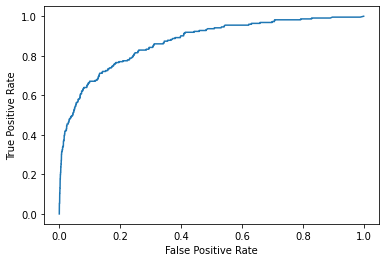

In [27]:
Analysis = pd.DataFrame({'Cols':df_trainX.columns,'Weights':model.feature_importances_})

In [28]:
Analysis.sort_values('Weights',ascending=False)

,Cols,Weights
8,avg_card_debt,0.197258
12,non_mtg_acc_past_due_12_months_num,0.184143
20,uti_card,0.106038
7,tot_credit_debt,0.060461
23,uti_card_50plus_pct,0.059470
22,uti_max_credit_line,0.058589
21,uti_50plus_pct,0.051898
9,credit_age,0.040327
10,credit_good_age,0.034044
16,inq_12_month_num,0.033375


In [29]:
#DFanalysis.to_csv('XGB.csv')

In [30]:
# ND = [] 
# for n in [50,100,150,200,500,750,1000]:
#     for d in [1,2,3,5]:
#         ND.extend([n+d])

In [31]:
#DFanalysis['ND'] = ND

In [32]:
DFanalysis.sort_values(['F1'],ascending=False)

,AUC,Accuracy,ConfMatrix,F1,FPR,Precision,Recall,TPR,Thresholds
0,0.848044,0.933,Predicted 0 1 Actual 0.0 ...,0.4,"[0.0, 0.0, 0.0, 0.0003599712023038157, 0.00035...",0.59292,0.301802,"[0.0, 0.0045045045045045045, 0.018018018018018...","[1.9999985201997217, 0.9999985201997217, 0.998..."
